In [1]:
import numpy as np
#%pip install simpy seaborn matplotlib
import simpy
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Parameters
LAMBDA = 1/12.5  # Average arrival rate (customers per time unit)
MU= 0.1  # Utilization factor
RHO = LAMBDA/MU # Utilization factor

times_in_system = []  # List to record time spent in system for each customer
num_customers_in_system = []  # Number of customers in the system at regular intervals



In [23]:
# calculation of expected lenght and waiting time in the system 
LS = RHO/(1-RHO) # Length of the system
WS = LS/LAMBDA # Waiting time in the system
LQ = RHO**2/(1-RHO) # Length of the queue
WQ = LQ/LAMBDA # Waiting time in the queue
p_0_3 = (1-RHO) + RHO*(1-RHO) + RHO**2*(1-RHO) # Probability of having 0, 1, 2, 3 customers in the system

In [24]:
# simulation processes
def customer(env, name, server):
    """Customer process. Customers arrive and get served."""
    arrival_time = env.now

    # Request a server
    with server.request() as req:
        yield req

        # Server is available, start service
        service_time = random.expovariate(MU)
        yield env.timeout(service_time)
        
        # Record the time spent in the system
        times_in_system.append(env.now - arrival_time)

def source(env, server):
    """Generate new customers."""
    i = 0
    while True:
        yield env.timeout(random.expovariate(LAMBDA)) # Generate new customers at random times
        i += 1
        env.process(customer(env, f"Customer-{i}", server))

def monitor(env, server, interval=1):
    """Monitor the number of customers in the system at regular intervals."""
    while True:
        num_customers_in_system.append(len(server.queue) + server.count)  # server.count is the number of customers currently being served
        yield env.timeout(interval)

In [41]:
# Setup and start the simulation
reached = False
MU = 0.1
LAMBDA = 1/12.5
SIM_TIME = 1000  # Simulation time in number of time units
times_in_system = []  # List to record time spent in system for each customer
num_customers_in_system = []  # Number of customers in the system at regular intervals
quantile_90 = np.float16(0)
while not reached:
    random.seed(42)
    env = simpy.Environment()
    
    # Start processes and run
    server = simpy.Resource(env, capacity=1)
    env.process(source(env, server))
    env.process(monitor(env, server))
    env.run(until=SIM_TIME)
    quantile_90 = np.quantile(times_in_system, 0.9)
    if quantile_90 <= np.float16(60):
        reached = True
    else:
        print(f'Got 90th percentile of {quantile_90}, with service rate {MU}')
        MU += 0.05
        times_in_system = []  # List to record time spent in system for each customer
        num_customers_in_system = []  # Number of customers in the system at regular intervals

print("Adjusted service rate: {}".format(MU))
print("90th percentile of time spent in the system: {}".format(quantile_90))

Got 90th percentile of 124.14212958676792, with service rate 0.1
Adjusted service rate: 0.15000000000000002
90th percentile of time spent in the system: 36.1498892050526


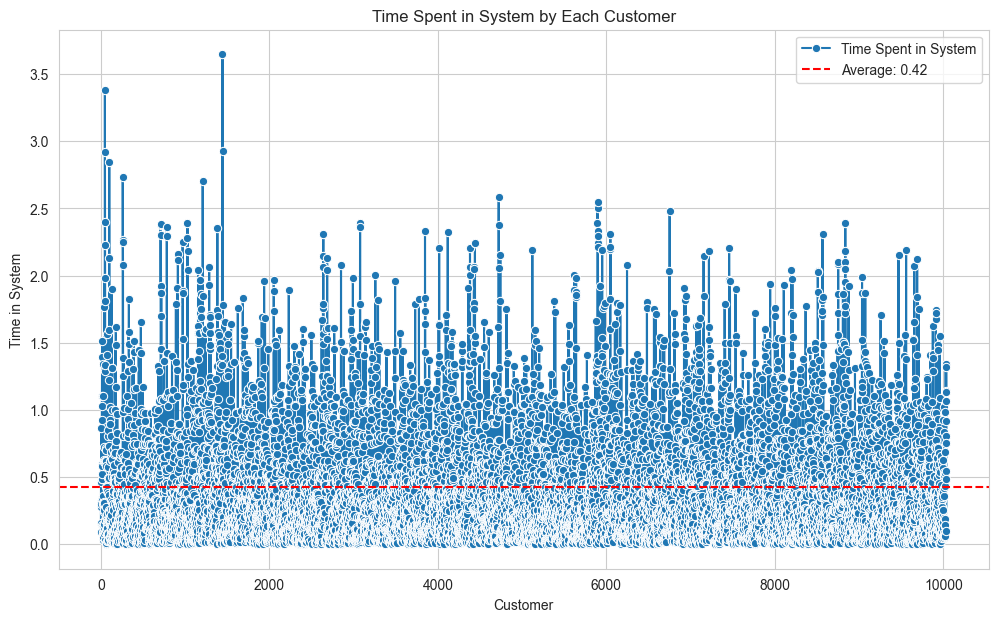

In [6]:
# Set the Seaborn style
sns.set_style("whitegrid")

# Compute the average time in system
avg_time = sum(times_in_system) / len(times_in_system)

# Plotting the times in system
plt.figure(figsize=(12, 7))
sns.lineplot(x=range(len(times_in_system)), y=times_in_system, marker='o', linestyle='-', label='Time Spent in System')
plt.axhline(avg_time, color='red', linestyle='--', label=f'Average: {avg_time:.2f}')
plt.title("Time Spent in System by Each Customer")
plt.xlabel("Customer")
plt.ylabel("Time in System")
plt.legend()
plt.show()

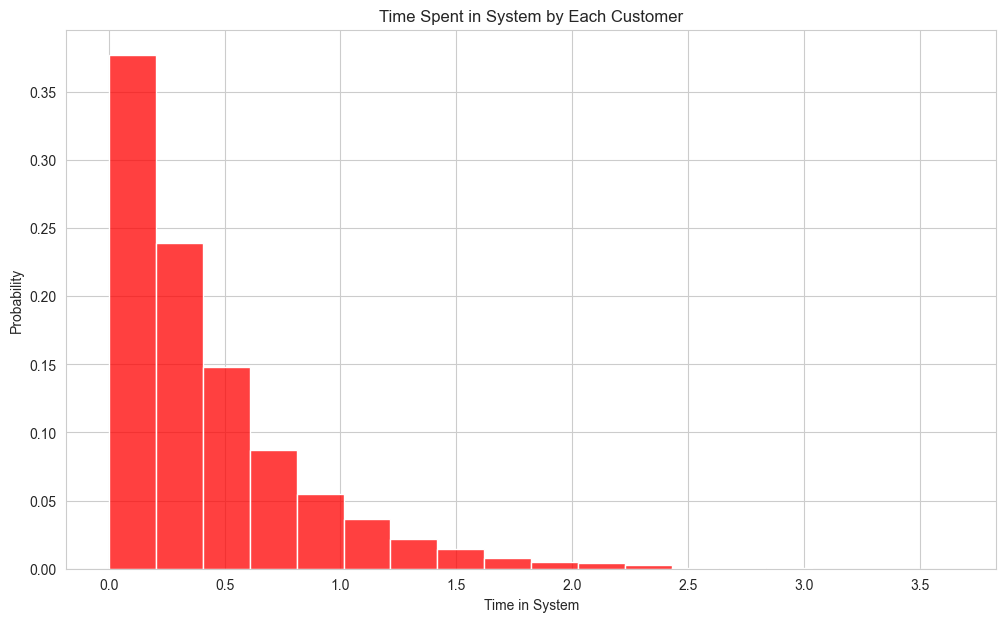

In [7]:
# create a histogram of the time spent in the system use 0.2 as the bin size
plt.figure(figsize=(12, 7))
sns.histplot(x=times_in_system, binwidth=0.2, stat="probability", color='red')
plt.title("Time Spent in System by Each Customer")
plt.xlabel("Time in System")
plt.ylabel("Probability")
plt.show()


In [8]:
# compare expected and simulated average time in system
print("simulated average time in system: {}".format(avg_time))
print("calculated average time in system: {}".format(WS))

simulated average time in system: 0.42306830805558643
calculated average time in system: -1.1111111111111112


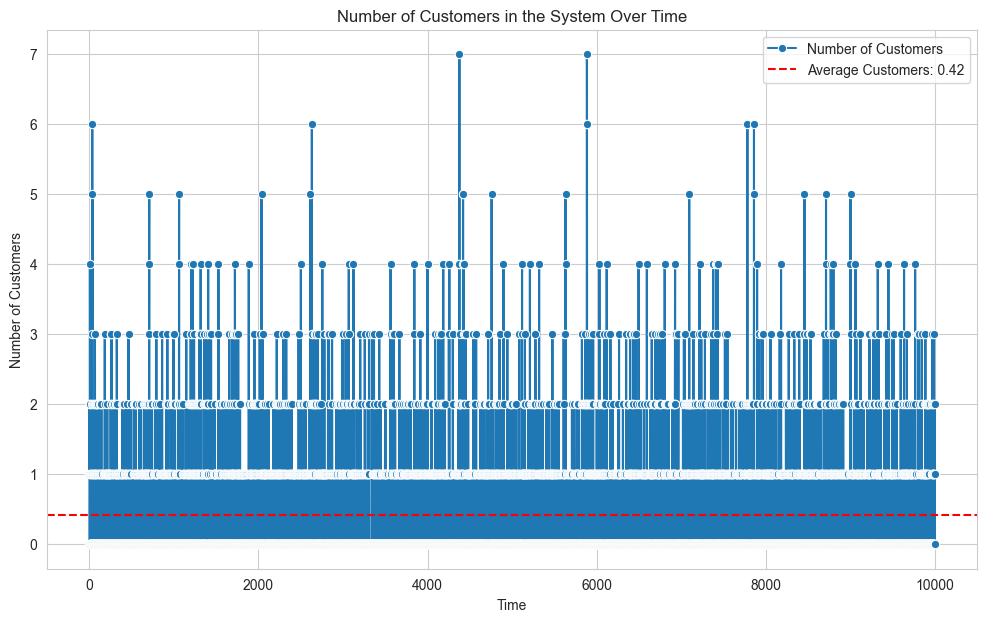

In [9]:
# Plotting the number of customers in the system
plt.figure(figsize=(12, 7))
sns.lineplot(x=range(len(num_customers_in_system)), y=num_customers_in_system, marker='o', linestyle='-', label='Number of Customers')
avg_customers = sum(num_customers_in_system) / len(num_customers_in_system)
plt.axhline(avg_customers, color='red', linestyle='--', label=f'Average Customers: {avg_customers:.2f}')
plt.title("Number of Customers in the System Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Customers")
plt.legend()
plt.show()

In [10]:
# compare simulated and expected average number of customers in the system
print("simulated average customers in system: {}".format(avg_customers))
print("calculated average customers in system: {}".format(LS))

simulated average customers in system: 0.4176
calculated average customers in system: -1.1111111111111112


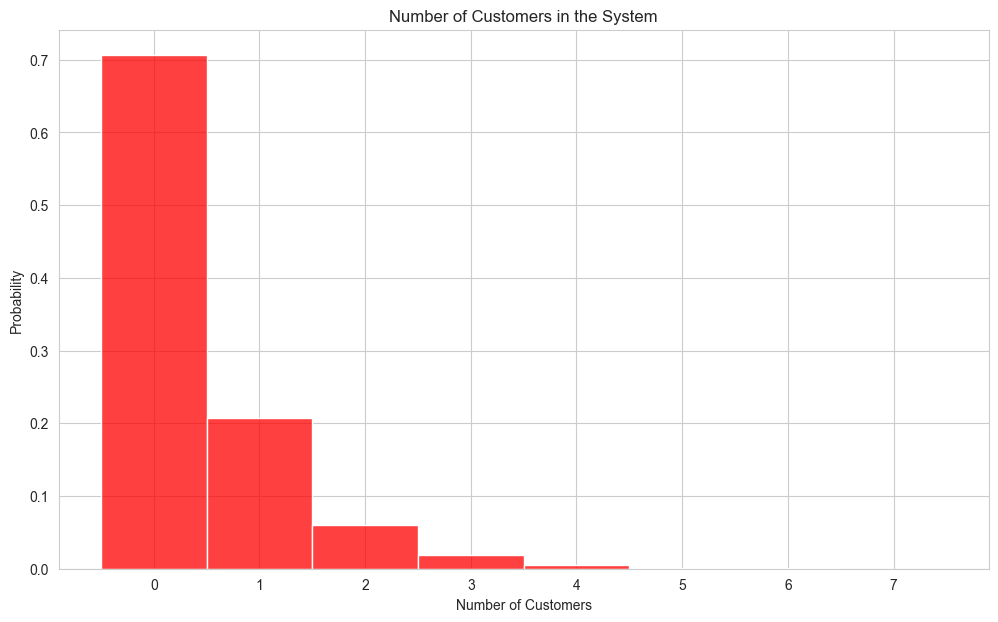

In [11]:
# histogram of numof customers in the system, x-axis ticks should be each integer
plt.figure(figsize=(12, 7))
sns.histplot(x=num_customers_in_system, stat="probability", color='red', discrete=True)
plt.title("Number of Customers in the System")
plt.xlabel("Number of Customers")
plt.ylabel("Probability")
plt.xticks(range(max(num_customers_in_system)+1))
plt.show()
